In [103]:
# Import required packages
import sys
# !{sys.executable} -m pip install seaborn
from glob import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from shutil import copy,move
from distutils.dir_util import copy_tree


In [2]:
# A helper dictionary and a save parameter
function_dict={'quad16qubit':'Quadratic','lin16qubit':'Linear','sin16qubit':'Sine'}
# params:
# -RUD: re-upload depth
# -AL: ansatz layer depth
#
# param_depth: either 3 or 5 layers
params=['RUD','AL']
param_depth=[3,5]
save=True

In [3]:
# baseline={}
# stacked_df=[]
# for idx,(k,v) in enumerate(sorted(function_dict.items())):
#     results={}
#     for i in glob(f"function-calc-test/fivequbit_tests/{k.replace('16','5')}/*/*results.json"):
#         dirname=os.path.basename(os.path.dirname(i))
#         with open(i,'r') as f:
#             results[dirname]=json.load(f)
#     baseline[k.replace('16','5')]=results
#     print(k)
#     print(pd.DataFrame.from_dict(results).T[['R2_train','R2_test']])
#     r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'})
#     stacked=r2_df.copy()
#     stacked['function']=len(stacked)*[v]
#     stacked_df.append(stacked)    
# # glob(f"function-calc-test/fivequbit_tests/{'quad16qubit'.replace('16','5')}/*/*results.json")

In [4]:
# encoders=set(i.split('_')[0] for i in stacked_df[0].index)
# ansatz=set(i.split('_')[1] for i in stacked_df[0].index)


# with open("encoders.json", "w") as f: 
#     json.dump(list(encoders), f)


# with open("ansatz.json", "w") as f: 
#     json.dump(list(ansatz), f)

# encoders_grouped={i:[j for j in stacked_df[0].index if j.split('_')[0]==i] for i in encoders}
# ansatz_grouped={i:[j for j in stacked_df[0].index if j.split('_')[1]==i] for i in ansatz}


# with open("encoders_grouped.json", "w") as f: 
#     json.dump(encoders_grouped, f)

# with open("ansatz_grouped.json", "w") as f: 
#     json.dump(ansatz_grouped, f)

In [5]:

with open("encoders.json", "r") as f: 
    encoders=json.load(f)


with open("ansatz.json", "r") as f: 
    ansatz=json.load(f)



with open("encoders_grouped.json", "r") as f: 
    encoders_grouped=json.load(f)
    
with open('ansatz_grouped.json','r') as f:
    ansatz_grouped=json.load(f)

In [6]:
def ax_format(ax,enc):
    ax.set_title(f"{enc}")    
    ax.set_xlabel('R$^{2}$')
    ax.set_ylabel('ENCODER_ANSATZ')
    ax.legend(loc=0)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlim(-1.2,1.2)
    for c in ax.containers:
        ax.bar_label(c, fmt='{:.2f}',fontsize=14)    

In [7]:
with open('function-calc-test/move2narval/mvlist.txt','r') as f:
        basenames=[basename.strip('\n') for basename in f.readlines()]            

compare_RUD_AL=[]
for k,v in function_dict.items():
    og_path=f"function-calc-test/sixteenqubit_test/{k}"
    

    for bn in basenames:
        og_results=os.path.join(og_path,bn,f"{bn}_results.json")
        with open(og_results,'r') as f:
            ogdict=json.load(f)
        for p in params:
            for param_d in param_depth:
                path_test=os.path.join('function-calc-test/move2narval/',f"{param_d}_{p}_{k}",bn,f"{bn}_results.json")

                if os.path.exists(path_test):
                    with open(path_test,'r') as g:
                        depth_dict=json.load(g)
        
                    if p=='AL':
                        compare_RUD_AL.append([v,bn,1,param_d,depth_dict['R2_train'],depth_dict['R2_test']])
                        
                    elif p=='RUD':
                        compare_RUD_AL.append([v,bn,param_d,1,depth_dict['R2_train'],depth_dict['R2_test']])
        compare_RUD_AL.append([v,bn,1,1,ogdict['R2_train'],ogdict['R2_test']])
compare_RUD_AL_df=pd.DataFrame(np.array(compare_RUD_AL),columns=['Function','ENCODER_ANSATZ','AL','RUD','Train','Test'])

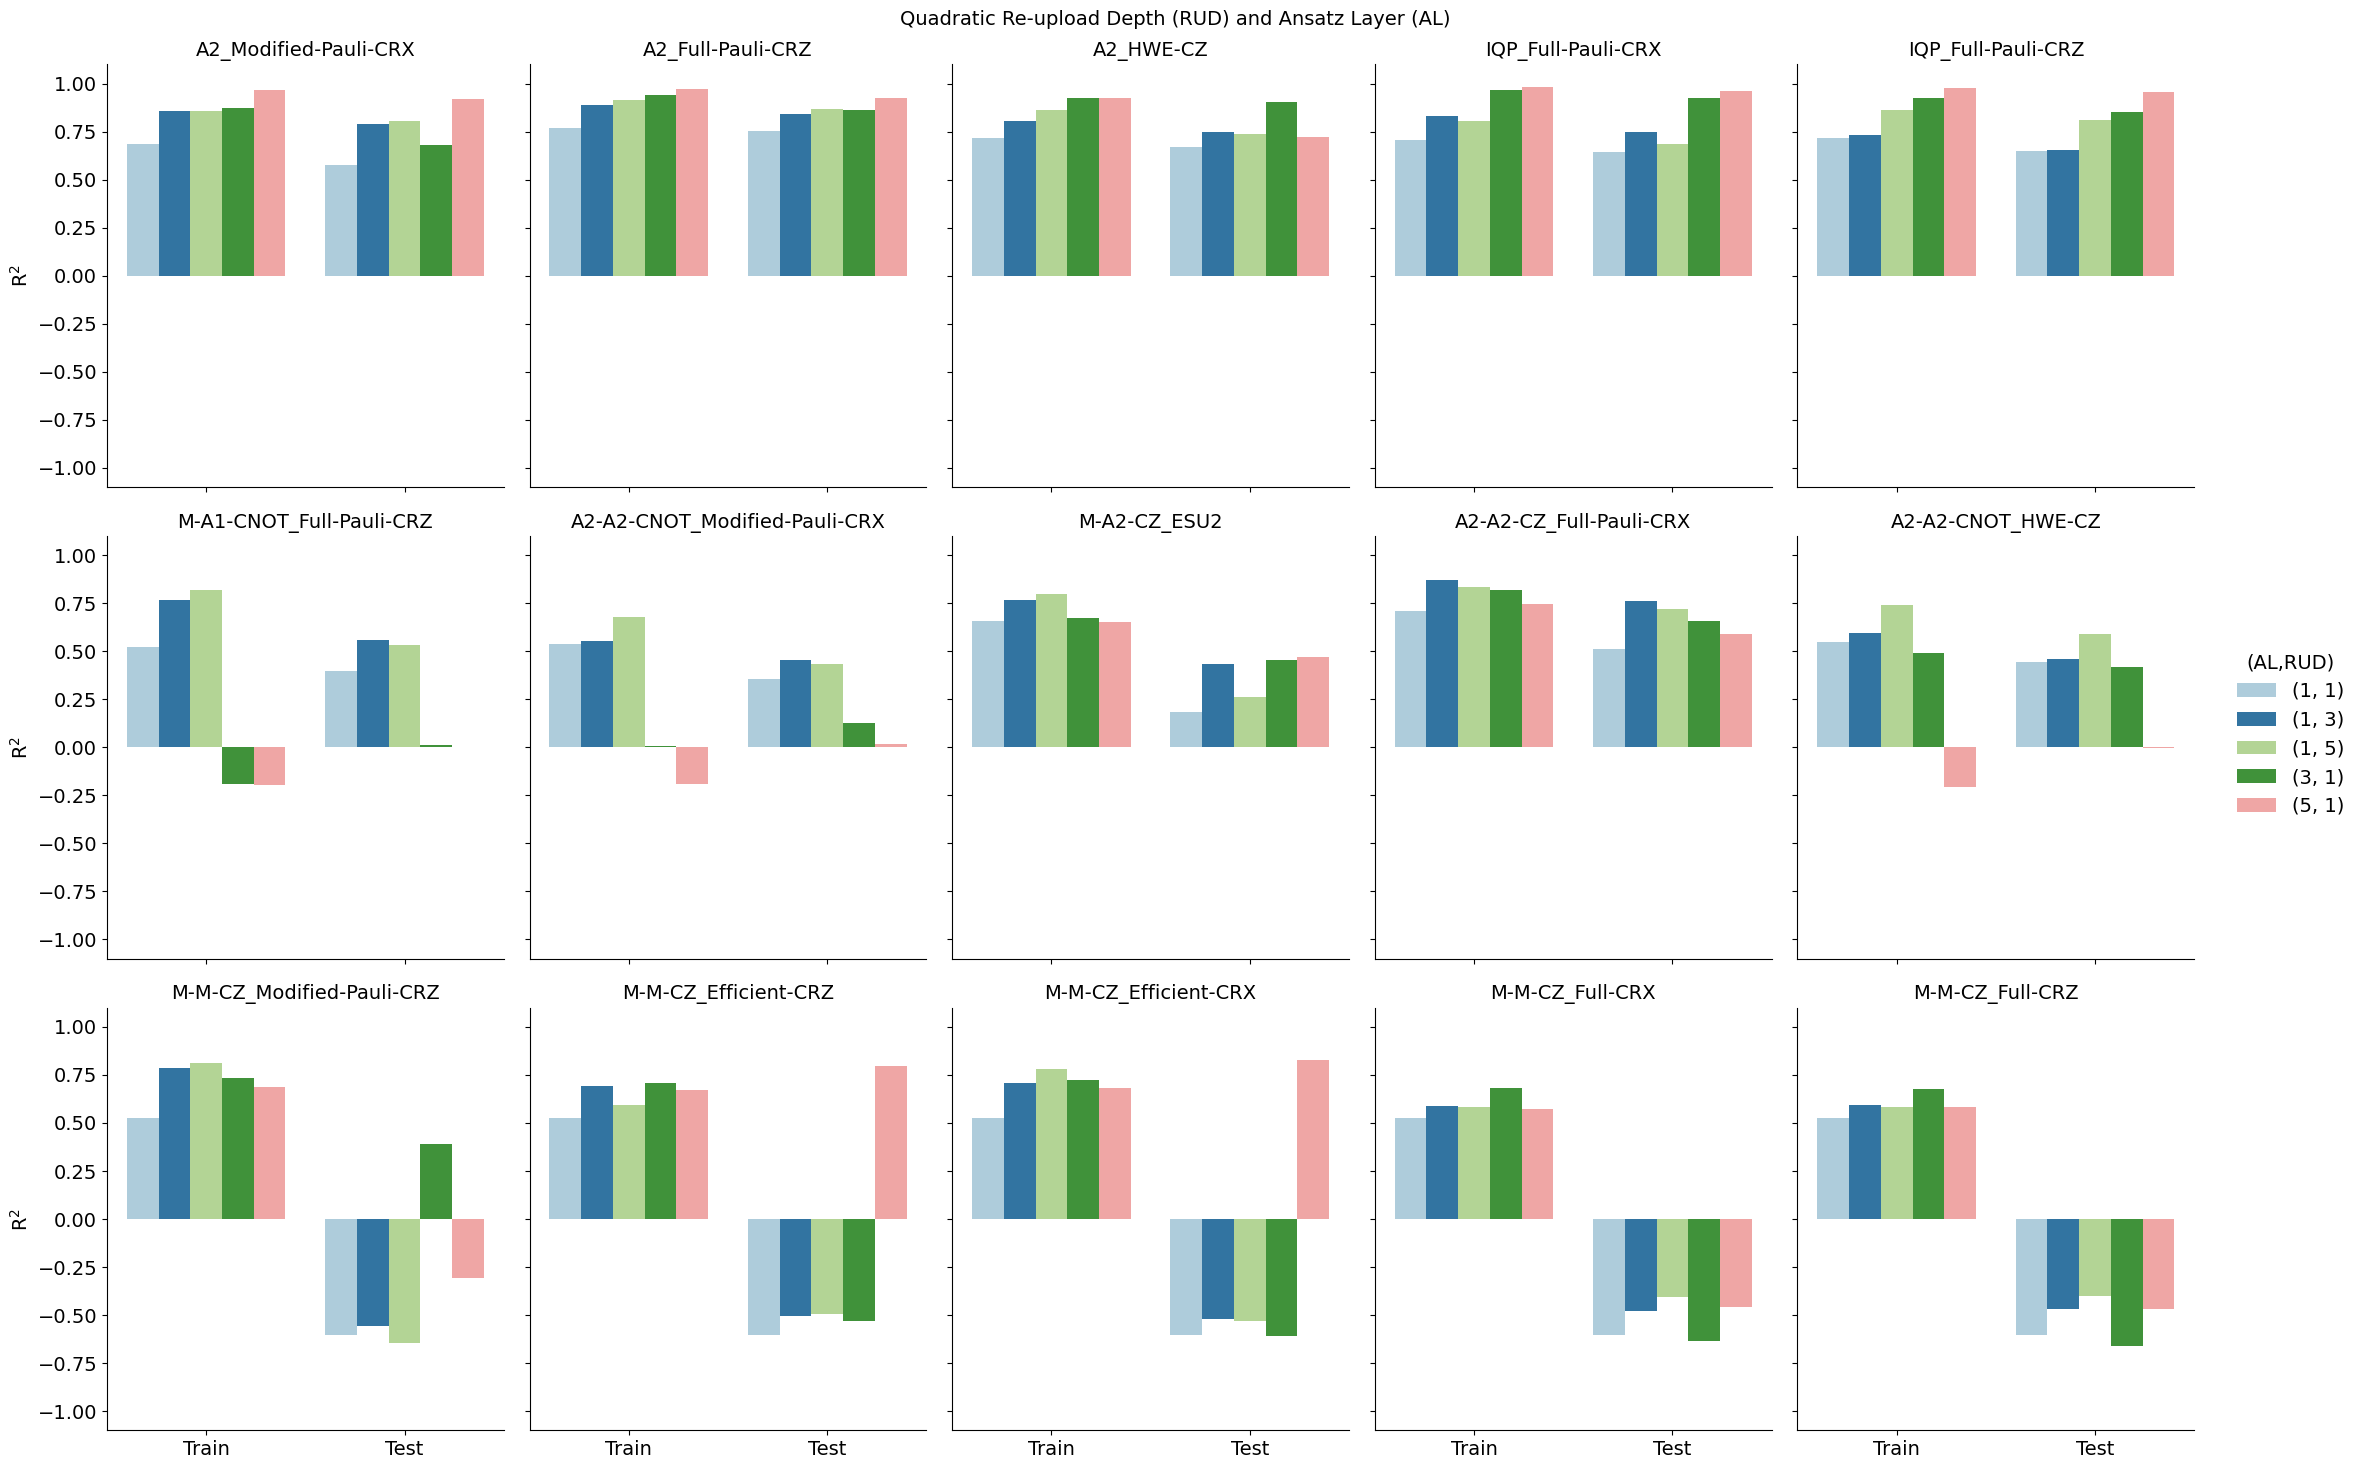

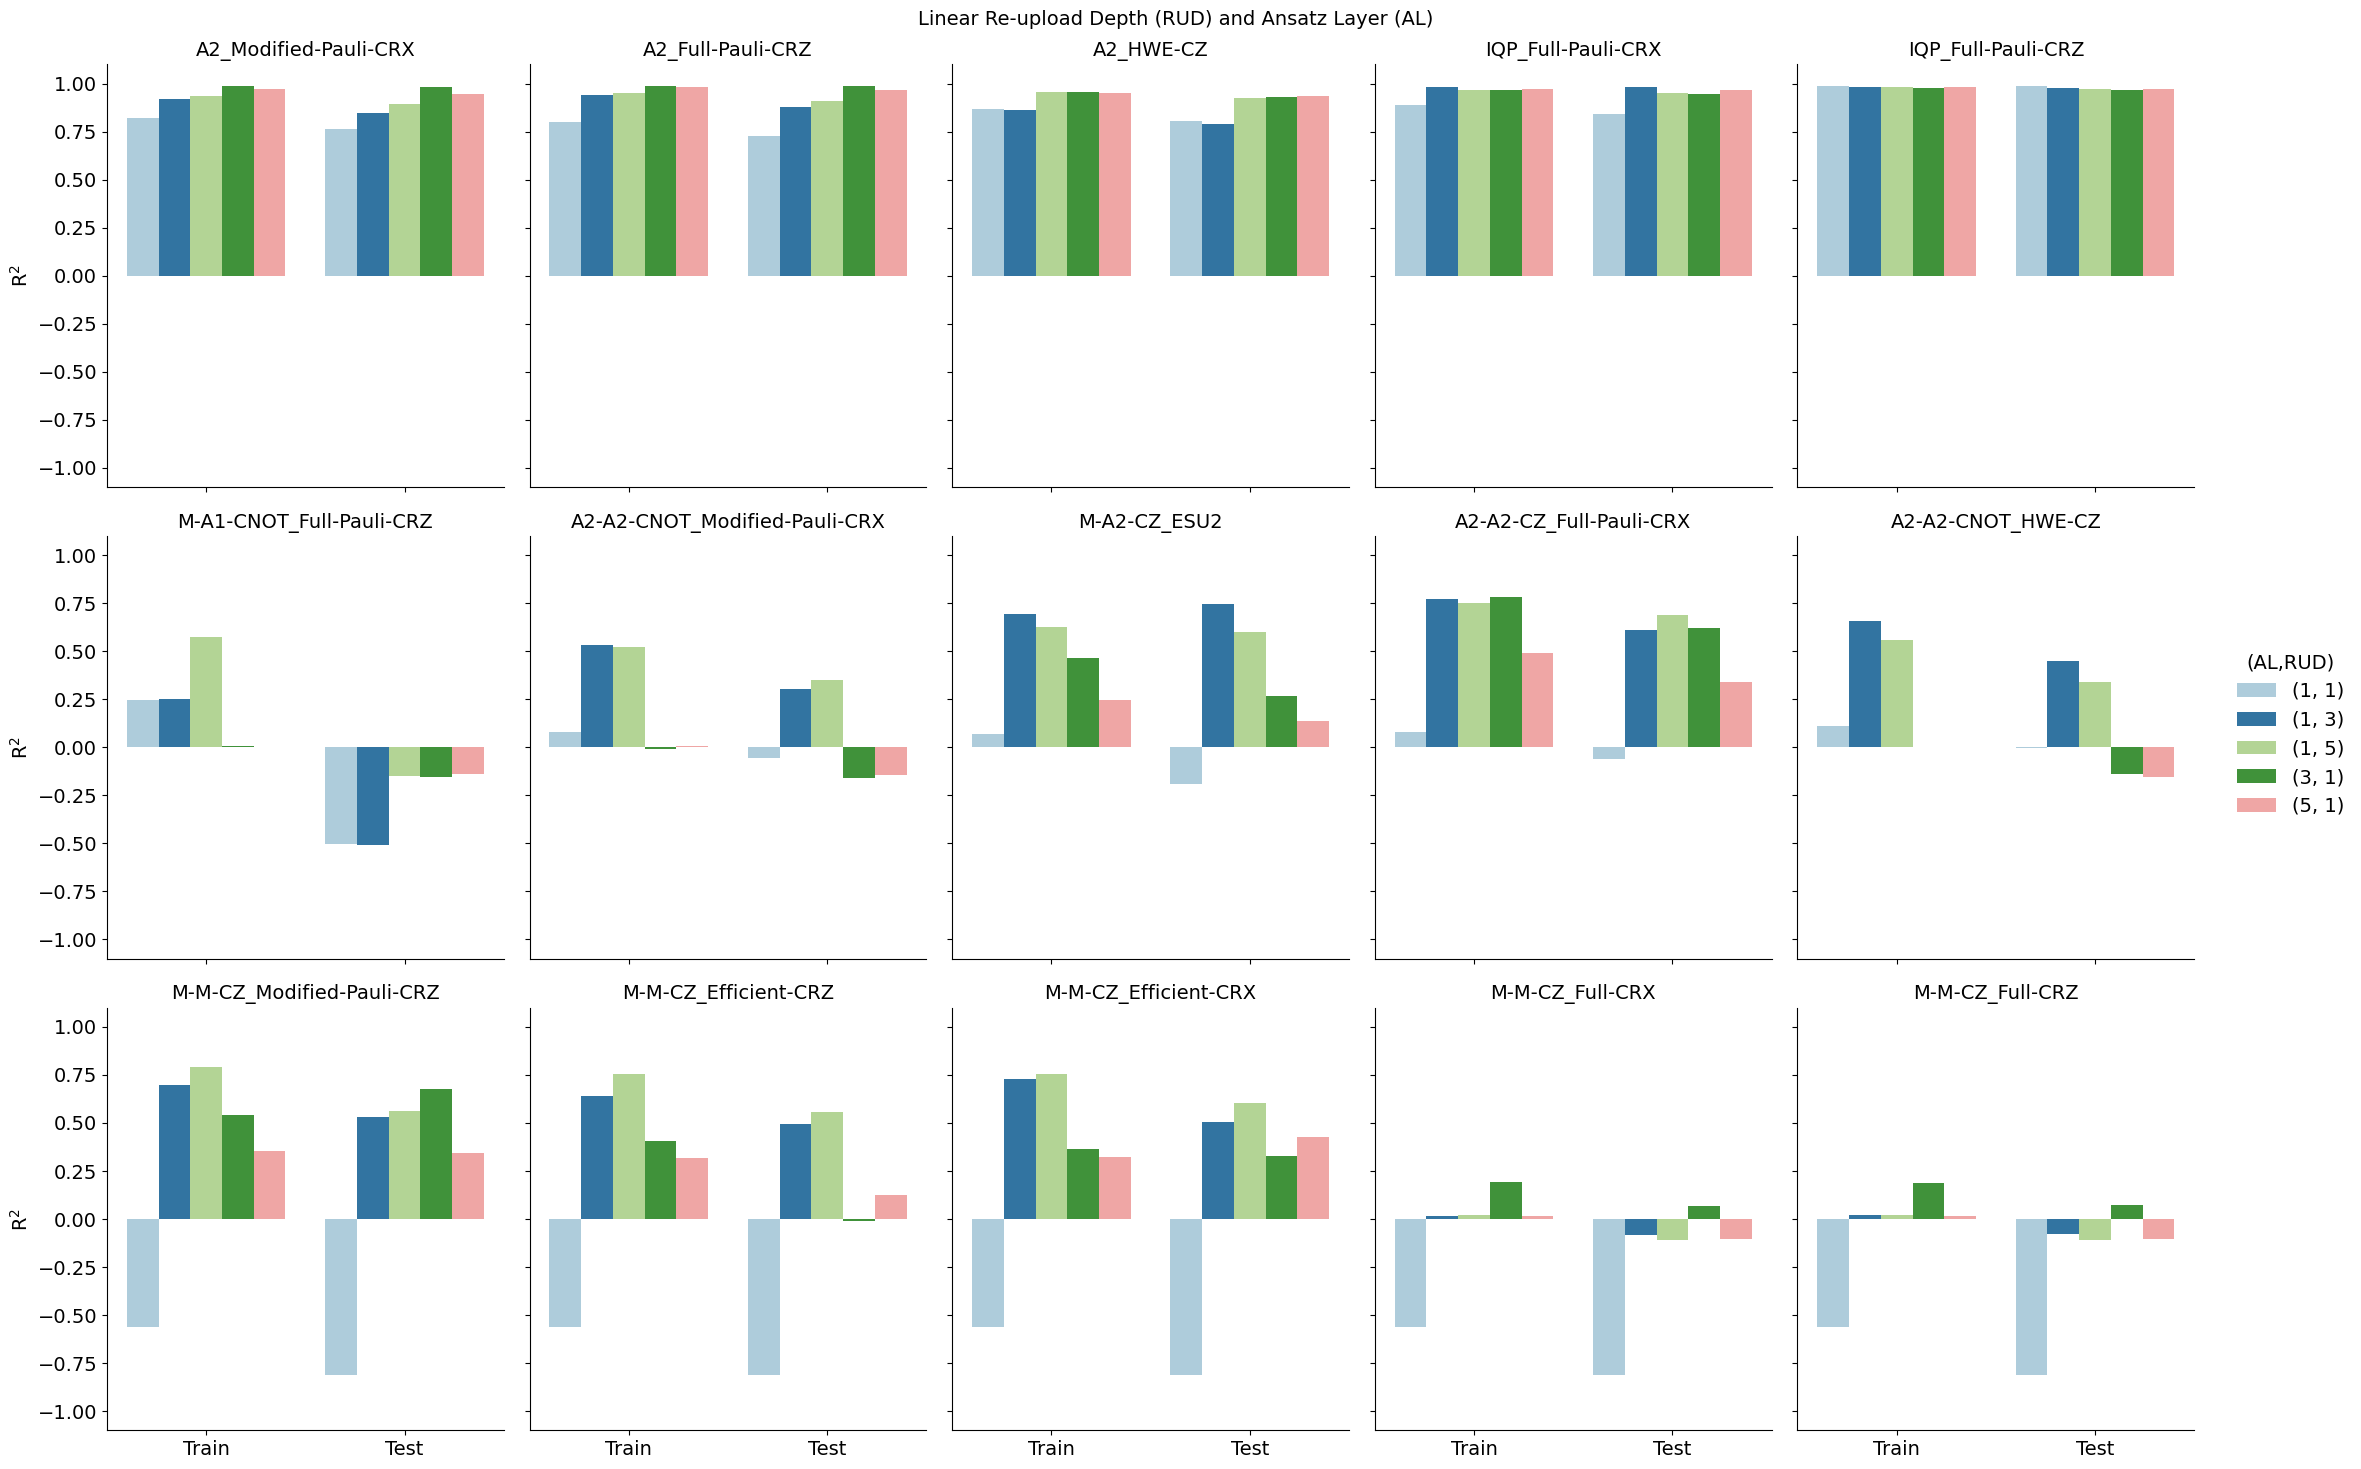

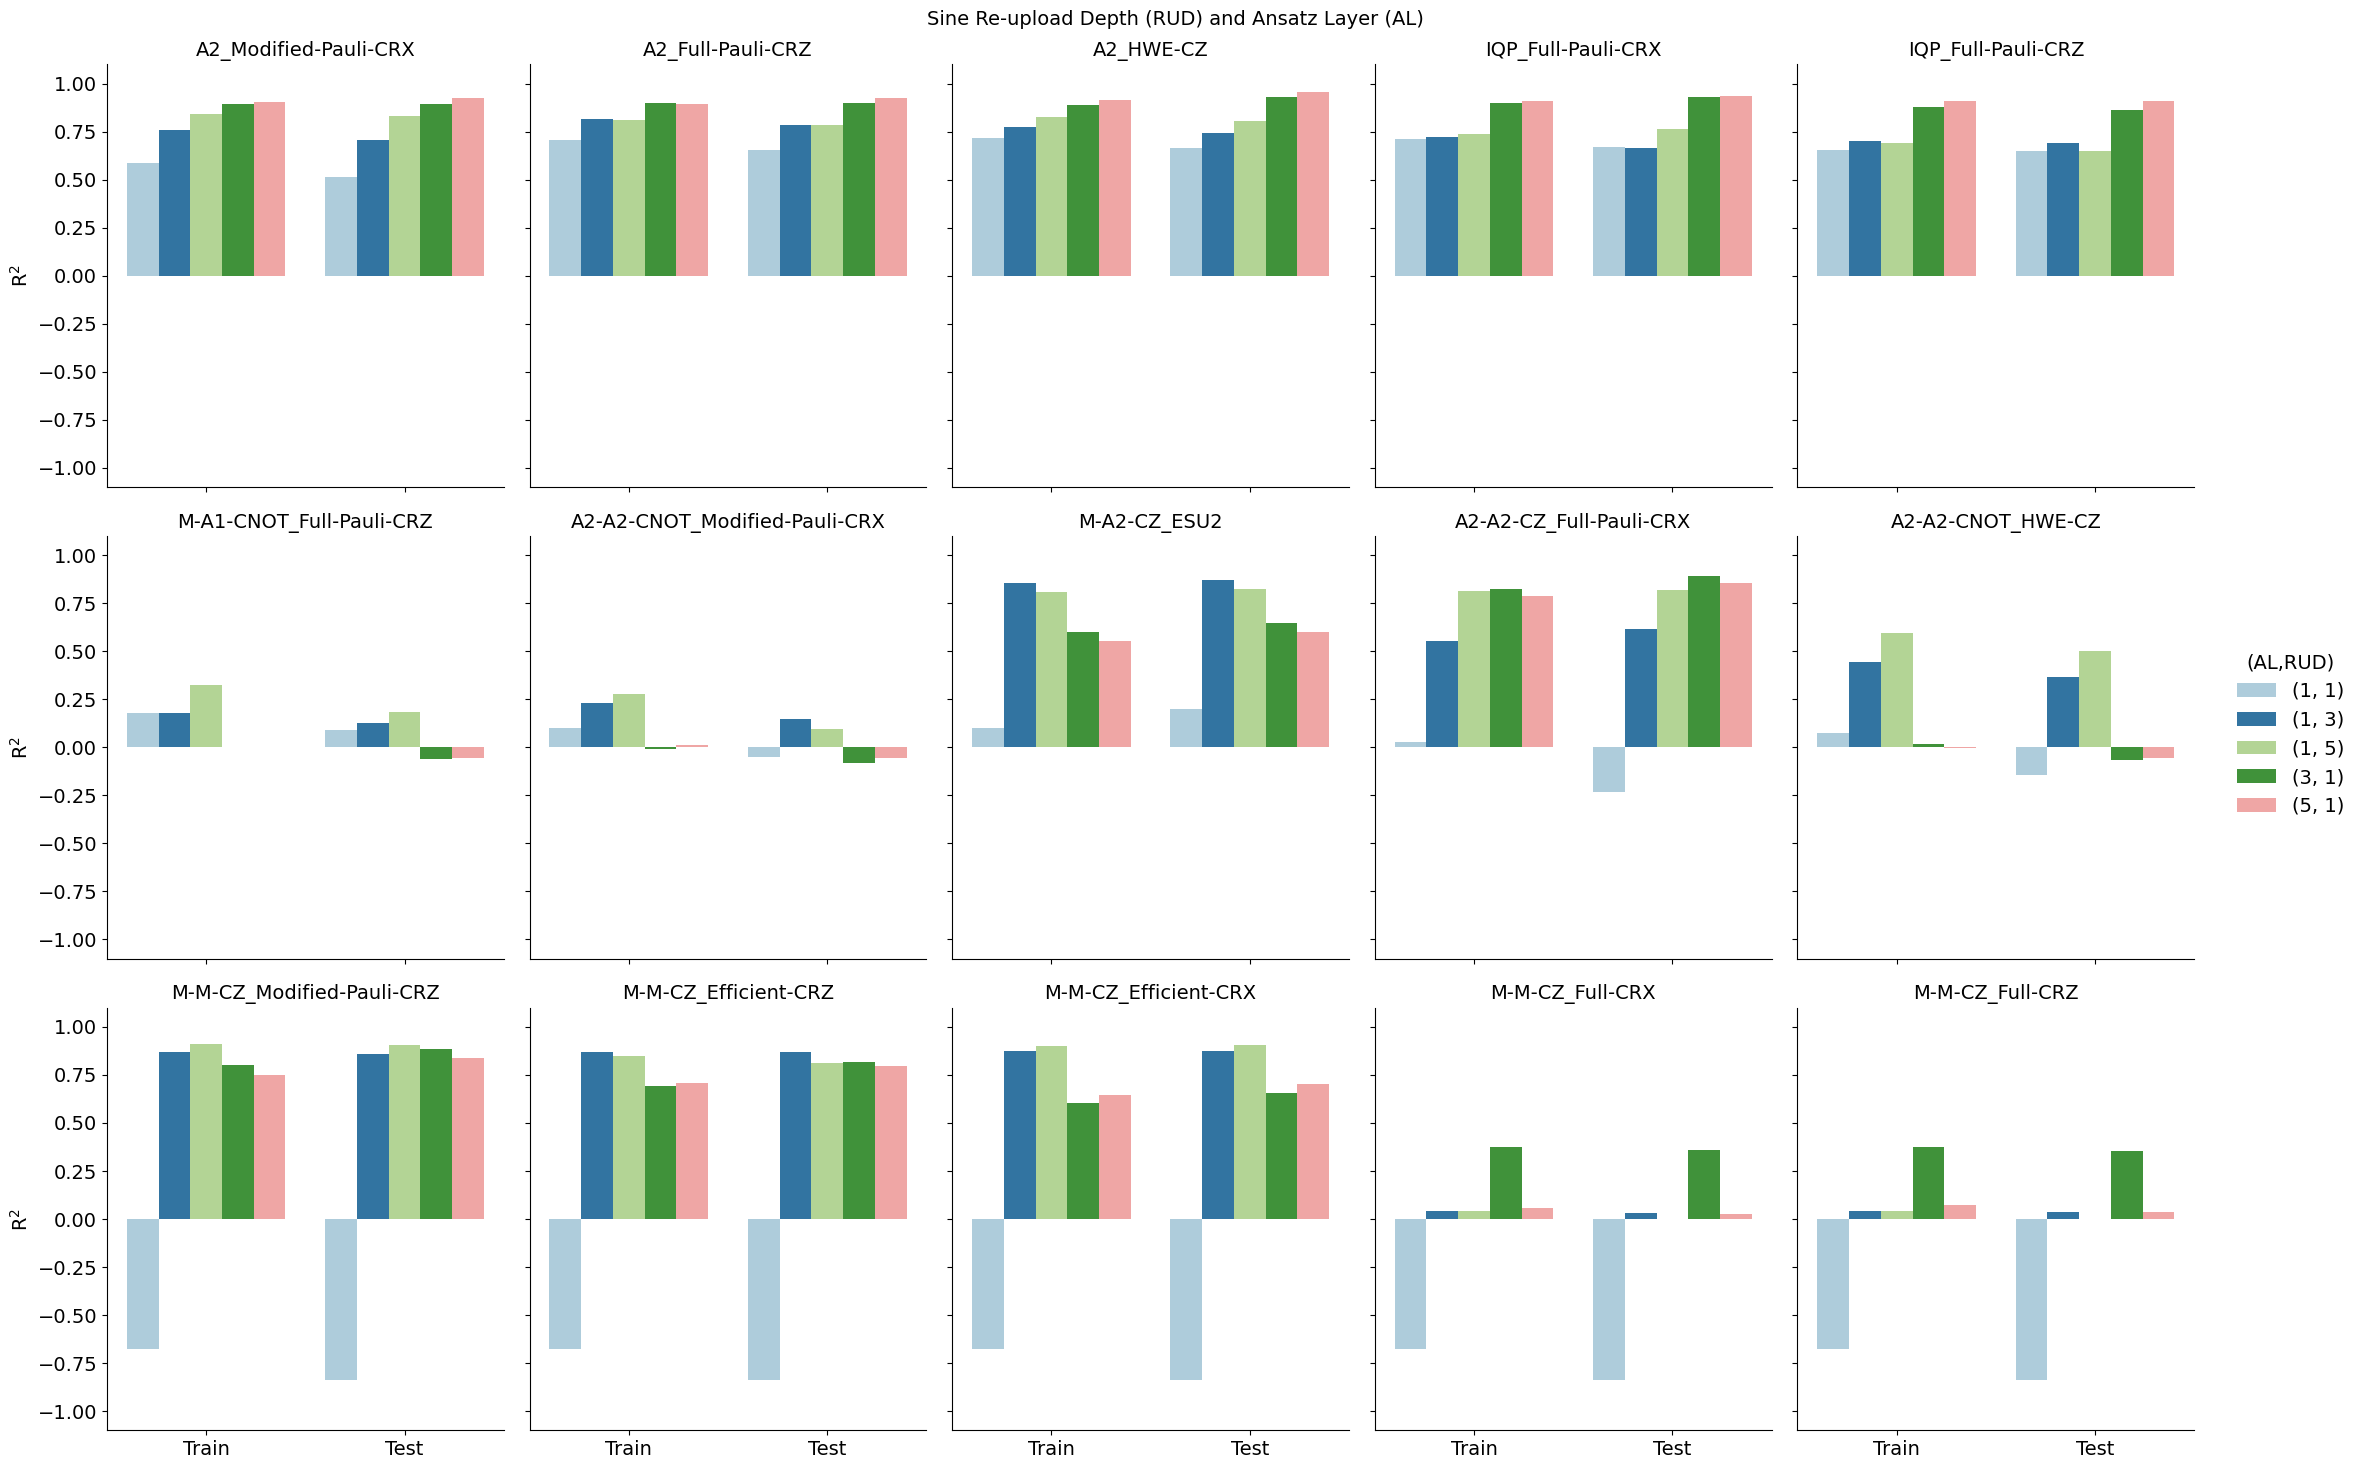

In [17]:
best_function={}
for k,v in function_dict.items():
    datadf=compare_RUD_AL_df[compare_RUD_AL_df['Function']==v].melt(id_vars=['ENCODER_ANSATZ','AL','RUD'], value_vars=['Train','Test']).astype({"AL":int,"RUD":int,"value":float})
    datadf["(AL,RUD)"]=datadf[["AL","RUD"]].apply(tuple, axis=1)
    datadf.drop(columns=["AL","RUD"],inplace=True)
    datadf=datadf.set_index('ENCODER_ANSATZ').loc[basenames].reset_index().astype({"(AL,RUD)":str})
    best_function[v]=datadf
    SMALL_SIZE = 8
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 12
    
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    
    g = sns.catplot(
        data=datadf, x="variable", y="value", col="ENCODER_ANSATZ",hue="(AL,RUD)",
        kind="bar", height=5, aspect=.9,palette=sns.color_palette('Paired',5),col_wrap=5,legend_out=True,hue_order=sorted(set(datadf["(AL,RUD)"]))
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("", "R$^{2}$")
    g.set(ylim=(-1.1, 1.1))
    g.fig.suptitle(f"{v} Re-upload Depth (RUD) and Ansatz Layer (AL)")
    g.tight_layout()
    plt.savefig(f"images/16qubit_{v}_RUD_AL.png",dpi=300,bbox_inches='tight')
    plt.show()

# The best is 'IQP_Full-Pauli-CRX' with 5 ansatz layers and 1 RUD

In [77]:
# findbest={}
# compare_RUD_AL_df=compare_RUD_AL_df.astype({"Train":float,"Test":float,'AL':int,'RUD':int})
# compare_RUD_AL_df['mean']=np.mean([compare_RUD_AL_df['Train'],compare_RUD_AL_df['Test']],axis=0)

# for bn in basenames:
#     datadf=compare_RUD_AL_df[compare_RUD_AL_df['ENCODER_ANSATZ']==bn]
#     # datadf["(AL,RUD)"]=datadf[["AL","RUD"]].apply(tuple, axis=1)
#     # datadf.drop(columns=["AL","RUD"],inplace=True)
#     findbest[bn]={}
#     for pd1,pd2 in [[1,1],[3,1],[5,1],[1,3],[1,5]]:
#         # print(pd1,pd2)
#         findbest[bn][f"{pd1}_{pd2}"]=datadf[(datadf['AL']==pd1)&(datadf['RUD']==pd2)]['mean'].mean()


# # The best is 'IQP_Full-Pauli-CRX' with 5 ansatz layers and 1 RUD
# print(pd.DataFrame.from_dict(findbest).max().max())
# print(pd.DataFrame.from_dict(findbest).max().idxmax())
# print(pd.DataFrame.from_dict(findbest).loc['5_1'].loc['IQP_Full-Pauli-CRX'])
# # compare_RUD_AL_df[(compare_RUD_AL_df['ENCODER_ANSATZ']=='IQP_Full-Pauli-CRX')&(compare_RUD_AL_df['AL'].astype(int)==5)].to_excel('spreadsheets/IQP_Full-Pauli-CRX_5AL_1RUD.xlsx')

In [117]:
# for i in glob("function-calc-test/best_learning_curves/*"):
#     print(os.path.basename(i))
#     print(os.listdir(i))
#     for j in np.arange(0.1,0.9,0.2):
#         path=os.path.join(i,f'{j:.1f}')
#         if os.path.exists(path)==False:
#             os.mkdir(path)
#         for k in glob(path+'*bin'):
#             move(k,path)
        
#     # move()

In [124]:
for i in glob("function-calc-test/best_learning_curves/*/*"):
    if os.path.isdir(i):
        print(i)
        copy_tree('function-calc-test/move2narval/5_AL_lin16qubit/IQP_Full-Pauli-CRX',i)

function-calc-test/best_learning_curves/quadratic/0.3
function-calc-test/best_learning_curves/quadratic/0.5
function-calc-test/best_learning_curves/quadratic/0.7
function-calc-test/best_learning_curves/quadratic/0.1
function-calc-test/best_learning_curves/linear/0.3
function-calc-test/best_learning_curves/linear/0.5
function-calc-test/best_learning_curves/linear/0.7
function-calc-test/best_learning_curves/linear/0.1
function-calc-test/best_learning_curves/sine/0.3
function-calc-test/best_learning_curves/sine/0.5
function-calc-test/best_learning_curves/sine/0.7
function-calc-test/best_learning_curves/sine/0.1


0.95436587258444

'IQP_Full-Pauli-CRX'

0.95436587258444

In [26]:
best_function['Quadratic'][best_function['Quadratic']['variable']=='Test'].sort_values(by='value')

,ENCODER_ANSATZ,variable,value,"(AL,RUD)"
145,M-M-CZ_Full-CRZ,Test,-0.662668,"(3, 1)"
108,M-M-CZ_Modified-Pauli-CRZ,Test,-0.645571,"(1, 5)"
135,M-M-CZ_Full-CRX,Test,-0.637306,"(3, 1)"
125,M-M-CZ_Efficient-CRX,Test,-0.611047,"(3, 1)"
109,M-M-CZ_Modified-Pauli-CRZ,Test,-0.601902,"(1, 1)"
...,...,...,...,...
6,A2_Modified-Pauli-CRX,Test,0.919538,"(5, 1)"
16,A2_Full-Pauli-CRZ,Test,0.922695,"(5, 1)"
35,IQP_Full-Pauli-CRX,Test,0.925105,"(3, 1)"
46,IQP_Full-Pauli-CRZ,Test,0.955301,"(5, 1)"


In [ ]:

baseline={}
stacked_df=[]
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    # Plot R^2
    fig,ax = plt.subplots(len(encoders_grouped)//2,2,figsize=(30,45),sharey=False,sharex=False)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 12
    
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    results={}
    for i in glob(f"function-calc-test/sixteenqubit_test/{k}/*/*results.json"):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    baseline[k]=results
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'}).reset_index().melt(id_vars='index').set_index('index')
    
    stacked=r2_df.copy()
    stacked['function']=len(stacked)*[v]
    stacked_df.append(stacked)
    for idx,(enc, anz) in enumerate(encoders_grouped.items()):
        if idx<=6:
            sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,0])
            ax_format(ax[idx%7,0],enc)
        else:
            sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,1])
            ax_format(ax[idx%7,1],enc)

    fig.suptitle(f'16 Qubit {v} Function Fitting',y=.99)
    plt.tight_layout()
    if save:
        plt.savefig(f'images/16qubit_{v}_funcfit_R2.png',dpi=300,bbox_inches='tight')
    plt.show()




In [ ]:
average_16_qubit={v:{enc:stacked_df[idx].loc[anz]['value'].astype(float).mean() for idxx,(enc, anz) in enumerate(encoders_grouped.items())} for idx,(k,v) in enumerate(function_dict.items())}
pd.DataFrame.from_dict(average_16_qubit).sort_index(axis=1).to_excel('spreadsheets/16qubit_mean_encoder.xlsx')

In [ ]:

baseline={}
stacked_df=[]
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    # Plot R^2
    fig,ax = plt.subplots(len(encoders_grouped)//2,2,figsize=(30,45),sharey=False,sharex=False)
    SMALL_SIZE = 8
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 12
    
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    results={}
    for i in glob(f"function-calc-test/fivequbit_tests/{k.replace('16','5')}/*/*results.json"):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    baseline[k.replace('16','5')]=results
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'}).reset_index().melt(id_vars='index').set_index('index')
    
    stacked=r2_df.copy()
    stacked['function']=len(stacked)*[v]
    stacked_df.append(stacked)
    for idx,(enc, anz) in enumerate(encoders_grouped.items()):
        if idx<=6:
            sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,0])
            ax_format(ax[idx%7,0],enc)
        else:
            sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,1])
            ax_format(ax[idx%7,1],enc)

    fig.suptitle(f'5 Qubit {v} Function Fitting',y=.99)
    plt.tight_layout()
    if save:
        plt.savefig(f'images/5qubit_{v}_funcfit_R2.png',dpi=300,bbox_inches='tight')
    plt.show()


# 
# plt.tight_layout()
# if save:
#     plt.savefig('5qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
average_5_qubit={v:{enc:stacked_df[idx].loc[anz]['value'].astype(float).mean() for idxx,(enc, anz) in enumerate(encoders_grouped.items())} for idx,(k,v) in enumerate(function_dict.items())}
pd.DataFrame.from_dict(average_16_qubit).sort_index(axis=1).to_excel('spreadsheets/5qubit_mean_encoder.xlsx')

In [ ]:

baseline={}

fig,ax = plt.subplots(len(encoders_grouped)//2,2,figsize=(30,45),sharey=False,sharex=False)
SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

results={}
for i in glob('BSE-calc-test/5qubit/*/*results.json'):
    dirname=os.path.basename(os.path.dirname(i))
    with open(i,'r') as f:
        results[dirname]=json.load(f)

r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'}).reset_index().melt(id_vars='index').set_index('index')

for idx,(enc, anz) in enumerate(encoders_grouped.items()):
    if idx<=6:
        sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,0])
        ax_format(ax[idx%7,0],enc)
        ax[idx%7,0].set_xlim(-3.5,1.2)
        ax[idx%7,0].legend(loc=3)
    else:
        sns.barplot(data=r2_df.loc[anz].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,1])
        ax_format(ax[idx%7,1],enc)
        ax[idx%7,1].set_xlim(-3.5,1.2)
        ax[idx%7,1].legend(loc=3)

fig.suptitle(f'5 Qubit BSE Fitting',y=.99)
plt.tight_layout()
if save:
    plt.savefig(f'images/5qubit_BSE_R2.png',dpi=300,bbox_inches='tight')
plt.show()


# 
# plt.tight_layout()
# if save:
#     plt.savefig('5qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
# plt.show()

In [ ]:
pd.DataFrame.from_dict({enc:r2_df.loc[anz]['value'].astype(float).mean() for idxx,(enc, anz) in enumerate(encoders_grouped.items())},orient='index').to_excel('spreadsheets/BSE5qubit_mean_encoder.xlsx')

In [ ]:

baseline={}

fig,ax = plt.subplots(len(encoders_grouped)//2,2,figsize=(30,45),sharey=False,sharex=False)
SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

results={}
for i in glob('BSE-calc-test/16qubit/*/*results.json'):
    dirname=os.path.basename(os.path.dirname(i))
    with open(i,'r') as f:
        results[dirname]=json.load(f)

r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'}).reset_index().melt(id_vars='index').set_index('index')

for idx,(enc, anz) in enumerate(encoders_grouped.items()):
    if idx<=6:

        sns.barplot(data=r2_df.loc[list(set(anz)&set(r2_df.index))].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,0])
        ax_format(ax[idx%7,0],enc)
        ax[idx%7,0].set_xlim(-3.5,1.2)
        ax[idx%7,0].legend(loc=2)
    else:
        sns.barplot(data=r2_df.loc[list(set(anz)&set(r2_df.index))].reset_index(),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx%7,1])
        ax_format(ax[idx%7,1],enc)
        ax[idx%7,1].set_xlim(-3.5,1.2)
        ax[idx%7,1].legend(loc=2)

fig.suptitle(f'16 Qubit BSE Fitting',y=.99)
plt.tight_layout()
if save:
    plt.savefig(f'images/16qubit_BSE_R2.png',dpi=300,bbox_inches='tight')
plt.show()



In [ ]:
pd.DataFrame.from_dict({enc:r2_df.loc[list(set(anz)&set(r2_df.index))]['value'].astype(float).mean() for idxx,(enc, anz) in enumerate(encoders_grouped.items())},orient='index').to_excel('spreadsheets/BSE16qubit_mean_encoder.xlsx')

In [ ]:
stacked_df=pd.concat(stacked_df)
# stacked_df.index=pd.MultiIndex.from_tuples(list(zip(stacked_df.index,stacked_df.function)))
# stacked_df=stacked_df.drop(columns='function')
# df=pd.DataFrame([stacked_df.loc[name].stack() for name in np.unique(np.array(list(stacked_df.index))[:,0])])
# df.index=np.unique(np.array(list(stacked_df.index))[:,0])

In [ ]:
# Plot R^2
fig,ax = plt.subplots(1,3,figsize=(30,45),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
baseline={}
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    baseline[k]=results
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'})
    sns.barplot(data=r2_df.reset_index().melt(id_vars='index'),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('R$^{2}$')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_xlim(-1.2,1.2)
    for c in ax[idx].containers:
        ax[idx].bar_label(c, fmt='{:.2f}',fontsize=14)    
fig.suptitle('16 Qubit Function Fitting',)
plt.tight_layout()
if save:
    plt.savefig('images/16qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:

stacked_all_16_df=pd.concat([pd.DataFrame.from_dict({k1:np.mean([v1['R2_train'],v1['R2_test']]) for k1,v1 in v.items()},orient='index').rename(columns={0:k}) for k,v in baseline.items()],axis=1).T.mean().sort_values()

In [ ]:
bottom_five=list(stacked_all_16_df[0:5].index)

In [ ]:
middle_five=list(stacked_all_16_df[(len(stacked_all_16_df)//2)-2:(len(stacked_all_16_df)//2)+3].index)

In [ ]:
top_five=list(stacked_all_16_df[-5:].index)

In [ ]:

# results={}
# for idx,(k,v) in enumerate(sorted(function_dict.items())):
#     results[k]={}
#     depth=[3,5]
#     layers=['RUD','AL']
#     for d in depth:
#         results[k][d]={}
#         for l in layers:
#             results[k][d][l]={}
#             for i in glob(f'function-calc-test/move2narval/{d}_{l}_{k}/*/*results.json'):
#                 dirname=os.path.basename(os.path.dirname(i))
#                 with open(i,'r') as f:
#                     results[k][d][l][dirname]=json.load(f)
#         # # print(dirname)
#         # with open(i,'r') as f:
#         #     results[dirname]={"baseline":baseline[k][dirname],"new":json.load(f)}

In [ ]:
# # Plot MAE (kcal/mol)
# # fig,ax = plt.subplots(1,3,figsize=(40,15),sharey=False)

# SMALL_SIZE = 8
# MEDIUM_SIZE = 24
# BIGGER_SIZE = 12

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
# compiled_data={}
# for idx,(k,v) in enumerate(results.items()):
#     plt.figure(figsize=(20,40))
#     stackedf=[]
#     for kd,vd in v.items():
#         for kl, vl in vd.items():
            
#             df=pd.DataFrame.from_dict(vl).loc[['R2_train','R2_test']].T.rename(columns={'R2_train':'Train','R2_test':'Test'}).sort_index().reset_index().melt(id_vars='index', value_vars=['Train','Test'])
#             df['variable']=['_'.join(t) for t in tuple(zip(df['variable'],len(df)*[str(kd)],len(df)*[kl]))]
#             stackedf.append(df)

#     stackeddf=pd.concat(stackedf)
    
#     basedf=pd.DataFrame.from_dict(baseline[k]).loc[['R2_train','R2_test']].T.rename(columns={'R2_train':'Train','R2_test':'Test'}).loc[list(set(stackeddf['index']))].sort_index().reset_index().melt(id_vars='index', value_vars=['Train','Test'])
#     basedf['variable']=['_'.join(t) for t in tuple(zip(basedf['variable'],len(basedf)*["baseline"]))]
#     alldf=pd.concat([stackeddf,basedf])
#     ax=sns.barplot(data=alldf,y='index',x='value',hue='variable',palette=sns.color_palette('Paired'),width=0.95)
#     # Fix legend labels
#     for text in plt.legend().get_texts():
#         text.set_text(' '.join([i for i in text.get_text().split('_')]))
#     # Add R2 to containers
#     for container in ax.containers:
#         ax.bar_label(container, fmt='{:.2f}',fontsize=MEDIUM_SIZE*0.75)

#     plt.ylabel('ENCODER_ANSATZ')
#     plt.xlabel("R$^{2}$")
#     plt.xlim(-1.1,1.1)
#     plt.title(f"{function_dict[k]} Re-upload and Ansatz Layers")
    
#     if save:
#         plt.savefig(f'{function_dict[k]}_16qubit_funcfit_R2_depth_layer.png',dpi=300,bbox_inches='tight')
#     plt.show()
#     compiled_data[k]=alldf

In [ ]:
def write_enc_anz():
    # SPlit names into encoder and ansatz
    enc_anz=np.array([i.split('_') for i in MAE_df.index])
    if save:
        with open('16qubit_enc_anz.txt','w') as f:
            f.write('Encoders\n')
            f.write(''.join(len('Encoders')*['-'])+'\n')
            for i in np.unique(enc_anz[:,0]):
                f.write(i+'\n')
            f.write('\nAnsatz\n')
            f.write(''.join(len('Ansatz')*['-'])+'\n')
            for j in np.unique(enc_anz[:,1]):
                f.write(j+'\n')

In [ ]:
# Create dictionary of results for linear, quadratic, and sine function
func_results={}
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    func_results[v]=results

In [ ]:
# # Find the best, worst, and middle 5 for linear function fitting
# lindf=pd.DataFrame.from_dict(func_results['Linear']).T[['R2_train','R2_test']]

# bottom_lin=lindf.T.mean().sort_values(ascending=False).iloc[-5:]
# top_lin=lindf.T.mean().sort_values(ascending=False).iloc[:5]
# linmed=len(lindf)//2
# middle_lin=pd.concat([lindf.T.mean().astype(float).sort_values().iloc[linmed-2:linmed],lindf.T.mean().astype(float).sort_values().iloc[linmed:linmed+3]],axis=0)

mv_lin=top_five+middle_five+bottom_five

In [ ]:
# # Find the best, worst, and middle 5 for quadratic function fitting
# quaddf=pd.DataFrame.from_dict(func_results['Quadratic']).T[['R2_train','R2_test']]
# bestfivequad=quaddf[quaddf>0].dropna().sort_values(by=['R2_test'],ascending=False).iloc[0:5]

# bottom_quad=quaddf.T.mean().sort_values(ascending=False).iloc[-5:]
# top_quad=quaddf.T.mean().sort_values(ascending=False).iloc[:5]
# quadmed=len(quaddf)//2
# middle_quad=pd.concat([quaddf.T.mean().astype(float).sort_values().iloc[quadmed-2:quadmed],quaddf.T.mean().astype(float).sort_values().iloc[quadmed:quadmed+3]],axis=0)

mv_quad=top_five+middle_five+bottom_five

In [ ]:
# # Find the best, worst, and middle 5 for sine function fitting
# sinedf=pd.DataFrame.from_dict(func_results['Sine']).T[['R2_train','R2_test']]
# bestfivesine=sinedf[sinedf>0].dropna().sort_values(by=['R2_test'],ascending=False).iloc[0:5]

# bottom_sine=sinedf.T.mean().sort_values(ascending=False).iloc[-5:]
# top_sine=sinedf.T.mean().sort_values(ascending=False).iloc[:5]
# sinemed=len(sinedf)//2
# middle_sine=pd.concat([sinedf.T.mean().astype(float).sort_values().iloc[sinemed-2:sinemed],sinedf.T.mean().astype(float).sort_values().iloc[sinemed:sinemed+3]],axis=0)

mv_sine=top_five+middle_five+bottom_five

In [ ]:
def write_mvlist():
    with open('function-calc-test/move2narval/mvlist.txt','w') as f:
        for i in mv_sine:
            f.write(f'{i}\n')

In [ ]:
mv_dict={'quad16qubit':mv_quad,'sin16qubit':mv_sine,'lin16qubit':mv_lin}

In [ ]:
def write_run(top_dir,work_dir,func,writefile):
    """
    Write run.sh to file

    params
    ------
    top_dir: str
        Name of top directory in scratch
    
    work_dir: str
        Name of test directory
        
    func: str
        Function being tested

    writefile: str
        Path and file name in directory

    """
    runfile="""#! /bin/bash
for i in */; do
    name=${i%/}
    # Extracting the parent directory name
    settings_folder=${name#M-A1-CNOT_Efficient-CRX_}"""+f"""
    path="/home/gjones/scratch/{top_dir}/{work_dir}"""+"""/${name}"
    if [ ! -f ${path}/${name}_results.json ]; then
        echo "${name}.done not found!"
    	cat > ${name}.sub <<EOF
#! /bin/bash
#SBATCH -t 0-12:00:00
#SBATCH -J """+f"""{work_dir}"""+"""_${name}
#SBATCH -N 1
#SBATCH -n 12
#SBATCH --account=rrg-jacobsen-ab
#SBATCH --error=${name}.e%J        # The file where run time errors will be dumped
#SBATCH --output=${name}.o%J               # The file where the output of the terminal will be dumped

module load apptainer 
cd $(pwd)/$name"""+f"""

apptainer run -C -B /home/gjones/scratch/{top_dir}/{work_dir} ~/deb.sif /opt/miniconda/bin/python /home/gjones/scratch/{top_dir}/{work_dir}/main.py"""+"""--save_path ${path}  --settings ${path}/${name}.json"""+f""" --train_set /home/gjones/scratch/{top_dir}/{work_dir}/{func}_train.bin --test_set /home/gjones/scratch/{top_dir}/{work_dir}/{func}_test.bin --scaler /home/gjones/scratch/{top_dir}/{work_dir}/{func}_scaler.bin"""+""" >> ${name}.out 2>&1 

cd ..
touch ${name}.done

EOF
    fi
    echo "Done ${name}.sub"
done
"""
    with open(writefile,'w') as f:
        f.write(runfile)

In [ ]:
def move_func_RUD_AL():
    # Move directories to new directory
    for idx,(k,v) in enumerate(sorted(function_dict.items())):
        for p in params:
            for pdepth in param_depth:
                dirname=f"{pdepth}_{p}_{k}"
                mv2narval=os.path.join(f'{os.getcwd()}/function-calc-test/move2narval/',dirname)
                if os.path.exists(mv2narval)==False:
                    os.mkdir(mv2narval)
                for subdir in mv_dict[k]:
                    copy_tree(f"{os.getcwd()}/function-calc-test/sixteenqubit_test/{k}/{subdir}",os.path.join(mv2narval,subdir))
                    # Write json files
                    jsonname=os.path.join(mv2narval,subdir,subdir+'.json')
                    with open(jsonname,'r') as f:
                        jsondict=json.load(f)
                    if p=='RUD':
                        jsondict['RE-UPLOAD_DEPTH']=pdepth
                    else:
                        jsondict['LAYERS']=pdepth
                    with open(jsonname,'w') as f:
                        json.dump(jsondict,f)
                        
    # Move data and helper files
    for k,v in function_dict.items():
        for subdir in glob(f'{os.getcwd()}/function-calc-test/move2narval/*_{k}'):
            # Move run.sh
            copy(f"{os.getcwd()}/function-calc-test/sixteenqubit_test/{k}/run.sh",subdir)
            for file in glob(f'{os.getcwd()}/function-calc-test/{v.lower()}/{v.lower()}*bin'):
                # Move data bin files
                copy(file,subdir)
            # Move helper files
            copy(f'{os.getcwd()}/function-calc-test/sixteenqubit_test/helperfiles.zip',subdir)
    # write run.sh
    for k,v in function_dict.items():
        print(v.lower())
        for filename in glob(f"./function-calc-test/move2narval/*{k}"):
            write_run("move2narval",os.path.basename(filename),v.lower(),os.path.join(filename,'run.sh'))
            # Copy resubmit.sh 
            copy(f"{os.getcwd()}/function-calc-test/sixteenqubit_test/lin16qubit/resubmit.sh",filename)


In [ ]:
def move_func_RUD_AL(n_qubit):
    
    for p in params:
        for pdepth in param_depth:
            if os.path.exists(f"BSE_RUD_AL_test/{n_qubit}qubit")==False:
                os.mkdir(f"BSE_RUD_AL_test/{n_qubit}qubit")
            newdir=f"BSE_RUD_AL_test/{n_qubit}qubit/{pdepth}_{p}"
            
            if os.path.exists(newdir)==False:
                os.mkdir(newdir)
    
            for dirname in basenames:
                newpath=os.path.join(newdir,dirname)
                        
                if os.path.exists(newpath)==False:
                    os.mkdir(newpath)
                ogdir=f'BSE-calc-test/{n_qubit}qubit/{dirname}'
            
                copy_tree(ogdir,newpath)
                
                jsonname=os.path.join(newpath,dirname+'.json')
                with open(jsonname,'r') as f:
                    jsondict=json.load(f)
                if p=='RUD':
                    jsondict['RE-UPLOAD_DEPTH']=pdepth
                else:
                    jsondict['LAYERS']=pdepth
                with open(jsonname,'w') as f:
                    json.dump(jsondict,f)
            helper=os.path.join(newdir,'helperfiles')
            if os.path.exists(helper)==False:
                os.mkdir(helper)
            for i in glob(f"BSE-calc-test/{n_qubit}qubit/*"):
                if '.' in i:
                    copy(i,newdir)
                if 'helperfiles' in i and os.path.isdir(i):
                    copy_tree(i,helper)

In [ ]:
move_func_RUD_AL(16)